<span style='font-family:"Times New Roman"'> <span style='font-size:20px'>
# <center>Shake Table Analysis Using Machine Learning Example: <br> Deep Neural Network Regression</center>
<br>
<br>
<center>Kayla Erler$^{1}$, Anirudha Agrawal$^{2}$, and Gilberto Mosqueda$^{1}$<center>
<br>
*<center>$^1$Department of Structural Engineering, University of California, San Diego, CA, U.S.A.<center>*
*<center>$^2$Department of Data Science, University of California, San Diego, CA, U.S.A.<center>*
 <br>
<br>
<strong><center>SUMMARY<center></strong>
<br>
<br>
<div style="text-align: justify">
In this series of notebooks focused on machine learning applications for shake sable data, regression analysis methods are explored. Linear regression is one of the most simple, straightforward, and commonly used methods available for structural engineers. The implementation of this method was developed in the previous Use Case in this series. Linear Regression was found to be lacking the detail needed to fully capture the nonlinear dynamic set of equilibrium equations involved in the lubricated and hydrostatic bearing. Friction is known to be a difficult physical phenomenon to properly capture. In this second notebook, a deep neural network (DNN) will be used to approximate the relationship between the inputs and target. DNNs without physics information included in the network architecture are often considered unreliable. For structural engineering applications, there is often much more information that can be provided to the algorithm in order to insure that the solution is physically possible. This iteration will not take that into consideration, as the formation of a physics informed neural network will be further studied in the subsequent notebook. This notebook, however, does represent a model that may be more flexible for training given any other set of input-output pairs a user may adjust it toward. The hyperparameter tuned model provides a rapidly convergent solution with far improved testing metrics over the linear regression solution. 
<br>
<br>


## References and Licensing
This report examines data from the seismic response modification device (SRMD) empty table runs. More details on the testing facility can be found at the following link:
> • [Caltrans Seismic Response Modification Device (SRMD) Test Facility](https://se.ucsd.edu/facilities/laboratory-listing/srmd)

The data published in DesignSafe and can be found in the link below:
> • [TBD] currently included in this directory

Refferences for the papers used to facilitate developement of the models in this project can be found at the following links:
> • [Shortreed et al. (2001)](https://royalsocietypublishing.org/doi/10.1098/rsta.2001.0875) "Characterization and testing of the Caltrans Seismic Response Modification Device Test System". Phil. Trans. R. Soc. A.359: 1829–1850
<br>
> • [Ozcelick et al. (2008)](http://jaguar.ucsd.edu/publications/refereed_journals/Ozcelik_Luco_Conte_Trombetti_Restrepo_EESD_2008.pdf) "Experimental Characterization, modeling and identification of the NEES-UCSD shake table mechanical systetm". Eathquake Engineering and Structural Dynamics, vol. 37, pp. 243-264, 2008



Citation and Licensing:
> •	[Erler et al. (2024 TBD)]
<br>
> •	[Rathje et al. (2017)](https://doi.org/10.1061/(ASCE)NH.1527-6996.0000246) "DesignSafe: New Cyberinfrastructure for Natural Hazards Engineering". ASCE: Natural Hazards Review / Volume 18 Issue 3 - August 2017
<br>
> •	This software is distributed under the [GNU General Public License](https://www.gnu.org/licenses/gpl-3.0.html).

## Prior Knowledge and Resources
This notebook is intended for users with some level of experience with python coding and a basic understanding of machine learning. Resources for these underlying principles are as follows:

1. [Introduction to Scientific Programming with Python](https://www.youtube.com/watch?v=ivZH9JUwvrc)

2. [An Example-Based Introduction to Common Machine Learning Approaches](https://www.designsafe-ci.org/rw/use-cases/#!#vantassel_and_zhang%2Fusecase%2F)

3. [Workshop on Artificial Intelligence in Natural Hazards Engineering](https://www.designsafe-ci.org/data/browser/public/designsafe.storage.published/PRJ-2767)

## Table of Contents
* [1. Introduction](#first-bullet)
* [2. Load and Install Python Libraries](#second-bullet)
* [3. Preprocess Data](#third-bullet)
* [4. Fit Physics Informed Neural Network](#fourth-bullet)
    * [4.1 Individual Hyperparameter Selection](#fourth1-bullet)
    * [4.2 Grid Search Hyperparameter Tuning](#fourth2-bullet)
    * [4.3 Model Testing and Saving](#fourth2-bullet)
* [5. Result Visualization](#fifth-bullet)
* [6. Conclusion](#sixth-bullet)

## 1. Introduction  <a class="anchor" id="first-bullet">
<div style="text-align: justify">
        Each notebook in this series becomes progressively more complex. All functions explicitly written and explained in previous notebooks will be added to pre and post processing functions so as to keep the working space clean and streamlined. This notebook emphasizes the development of a deep neural network (DNN) using a PyTorch implementation. A grid search is written to allow for automated hyperparameter tuning. The selection below allows the user to control which type of test they would like to conduct. By default, a pre-trained model is executed to allow interaction with the post-processing tools without the need to wait for training time. All training notebooks automatically save the trained model with hyperparameters to the resutlts folder. If this notebook is tested while in community data, some functions may not be applicable as the user will not have writing permission. If full model training is desired, it is recommended for the user to download this code and its functions to their own project space either on Design Safe or to their local machine. The user can decide to conduct training with specified hyperparameters or to conduct a full grid search for the hyperparameters. Note that it is advised to use a platform with accessible GPU for the grid search as it uses a significant ammount of time and computer resources. 

In [5]:
######### Select Desired Notebook Mode ####################
# 1 for training with inputted hyperparameters
# 2 for training with grid search selected hyperparameters
# 3 for loading pre-trained model and exploring post-processing features alone
notebook_mode = 2

# Modify the following variables to change the primary functions of the notebook
model_version = 3            # use to load a specific model version for mode 3 or to train a new model version for mode 1 or 2
model_type = 'DNN'           # enter the model type
load_hypers_from_file = True # set to true to use the hyper_path or hyper_grid_path for modes 1 or 2, respectively
save_results = True          # set to False if in read only mode on DesignSafe 
load_new_model = False       # set to true to load a new model from hyper_new_model_path for mode 1

# below parameters are default and should not need to be altered
current_model_name = "modelv" + str(model_version)                                # enter model name
results_folder = model_type + 'Results'                                            # enter the path to the results folder
config_folder  = model_type + 'configs'                                            # enter the path to the config folder
hyper_new_model_path = config_folder + '/' + current_model_name + '.yaml'          # enter the path to the hyperparameters you want to use for notebook_mode 1
hyper_grid_path = config_folder + '/hyper_tuning_v' + str(model_version) + '.yaml' # enter the path to the hyperparameters you want to use for notebook_mode 2
saved_hyper_path = results_folder + '/' + current_model_name + '_config.yaml'       # enter the path to save the hyperparameters for notebook_mode 1 or 2 or to load for mode 3
saved_model_path = results_folder + '/' + current_model_name                       # enter the path to save the model for notebook_mode 1 or 2 or to load for mode 3
norm_params_path = results_folder + '/' + current_model_name + '_norm_params.npy'   # enter the path to save the normalization parameters for notebook_mode 1 or 2 or to load for mode 3
hyper_grid_results = results_folder + '/' + current_model_name + '_hyper_grid.csv' # enter the path to save the hyperparameter tuning results for notebook_mode 2

normalize_data_set = True # generally this value will always be true for training neural networks
data_stored = True        # enter False if you want to reprocess the data rather than using the current preprocessed data

## 2. Load and Install Python Libraries <a class="anchor" id="second-bullet">
The python libraries listed below need to be installed on the initial run with the currently activated server or every three days. All other libraries should be installed on the updated image for DesignSafe.

In [6]:
!pip install --quiet scikit-learn
!pip3 install --quiet torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

The python libraries used in the primary code for the notebook are shown below.

In [7]:
# python files created for this project
import preprocess_data
import post_process
import DNN_functions

# Open source libraries available in python
import yaml
import numpy as np
import torch
import torch.nn as nn

#in case underlying files need updating while the notebook is running
import importlib
importlib.reload(preprocess_data)
importlib.reload(post_process)
importlib.reload(DNN_functions)

<module 'DNN_functions' from 'c:\\Users\\kerler\\Documents\\Design Safe\\Structural-Insights-with-ML\\DNN_functions.py'>

## 3. Preprocess Data <a class="anchor" id="third-bullet">
<br>
<div style="text-align: justify">
     "Case 0. PreprocessingVisualization.ipynb" included with this project shows the underlying filter functions that are implemented here. All data is passed through this process. The data is able to be normalized using z-score normalization at this initial step or later in the feature developement. Normalization provides zero mean and unit standard deviation on a signal-wise basis. By default, the entire dataset is extracted from the ET_Runs folder, which contains 87 test runs. The available data contains significant differences in run length. 

Run the following block to call the load_data_set function and save the parameters needed to inverse normalize. 

*If using this code on the DesignSafe community data, it is not possible to save the preprocessed data to files as the user will not have writing permissions. Potential solutions if an alteration of the preprocessing is desired: 
1. The user is welcome to download the notebooks to their own directory and change the source directory (Mpath) for data extraction from the current working directory to ....... 
2. Change the store_data variable to False so that the new preprocessing method is implemented without storing it

In [8]:
# load data set from individual testing files or with preprocessed data
signals_test, signals_train_val, signals_train, signals_val, norm_params, force_SRMD_test = preprocess_data.load_data_set(
    norm_params_directory = norm_params_path, 
    model_type = model_type,
    data_stored = data_stored, 
    store_data = save_results, 
    normalize_data_set = normalize_data_set)

Loading Stored Data


## 4. Fit Deep Neural Network <a class="anchor" id="fourth-bullet">
<div style="text-align: justify">
    As the code for the deep neural network is comprised of many bulky underlying functions, it has been packaged together in the DNN_functions.py file. These functions will be implemented in the below testing and training procedures. Please view the python code and files for full descriptions on their input variables and functionality. 

### 4.1 Individual Hyperparameter Selection <a class="anchor" id="fourth1-bullet">
This section of code implements the first of three model modes. The training of a model with specific hyperparameters can be performed by either writing in the desired hyperparameters if the variable load_hypers_from_file is False or the selected path can be accessible to load the coonfigurable file for hyperparameter selection. The benefit of using the configuration file for hyperparameter selection is the ability to save these configuration files to keep track of experiments. 
<br>
Training will be performed using GPU if available, otherwise, the model runs on GPU. The hyperparameters selected for tuning, do not span the potential hyperparameters that could be used for model improvement; however, they have been found to provide sufficient variability for the purposes of the model. 

In [9]:
if notebook_mode == 1:
    criterion = nn.MSELoss()
    if load_hypers_from_file:
        if load_new_model:
            print('Loading hyperparameters from file: ' + hyper_new_model_path)
            hyperparameters = yaml.load(open(hyper_new_model_path, 'r'), Loader=yaml.SafeLoader)
        else:
            print('Loading hyperparameters from file: ' + saved_hyper_path)
            hyperparameters = yaml.load(open(saved_hyper_path, 'r'), Loader=yaml.SafeLoader)
    else:
        print('Using mannually inputed hyperparameters')
        hyperparameters = {
            'neurons_per_layer': [2],
            'activation': 'relu',
            'learning_rate': 0.01,
            'batch_size': 512,
            'num_epochs': 2
        }
    # Train and test the model
    model, r2_train = DNN_functions.train_model(signals_train_val, criterion, hyperparameters, training_output = 2)
    test_predictions, r2_test = DNN_functions.test_model(model, signals_test)
    torch.save(model.state_dict(), saved_model_path)
    yaml.dump(hyperparameters, open(saved_hyper_path, 'w'))

### 4.2 Gridsearch Hyperparameter Tuning <a class="anchor" id="fourth2-bullet">
It is well known that the selection of the best hyperparameters is not a straight forward process as different sets will work better for different problems wihtout a general trend between datasets. To address hyperparameter selection, the second notebook mode implements a full hyperparameter grid search. Note this process could take hours to multiple days dependent on the complexity of the grid and number of epochs being tested. The grid search trains and tests the full data set for every possible hyperparameter combination defined by param_grid. The hyperparameters and their test scores are then saved to a csv file in order for the user to gain more insight on the fluctuation of results within a general region of the grid. Using a broad sparse grid to start and finding model trends then zooming in to regions that provided good results is a good way to attain the desired parameters. 

In [10]:
if notebook_mode == 2:
    criterion = nn.MSELoss()
    if load_hypers_from_file:
        print('Loading hyperparameters from file: ' + hyper_grid_path)
        param_grid = yaml.load(open(hyper_grid_path, 'r'), Loader=yaml.SafeLoader)
    else:
        print('Using mannually inputed hyperparameter grid')
        param_grid = {
            'neurons_per_layer': [[30, 50, 20], [30, 50, 100, 40, 20], [30, 50, 100, 500, 100, 50, 30], [30, 50, 100, 300, 500, 200, 100, 50 ,30, 10]],
            'activation': ['relu','leaky_relu'],
            'learning_rate': [0.0001, 0.001, 0.01],
            'batch_size': [500, 1000, 2000, 5000],
            'num_epochs': [10, 100, 1000, 10000]
        }
    DNN_functions.grid_search(param_grid, signals_train_val, signals_test, saved_model_path, saved_hyper_path, hyper_grid_results)

Loading hyperparameters from file: DNNconfigs/hyper_tuning_v2.yaml


KeyError: 'hidden_neurons'

### 4.3 Load Pre-Trained Model <a class="anchor" id="fourth3-bullet">
The final mode possible for this notebook is loading a pre-trained model. It is neccesary to have the hyperparameter configuration file corresponding to the trained model loaded in order to initialize the network. Once the model has been loaded, the user can predict on any given dataset that matches the number of features provided in the initial model. The interactive plots in the next section will be viewable to see model trends. 

In [ ]:
if notebook_mode == 3:
    model = DNN_functions.initiate_saved_model(saved_hyper_path, saved_model_path)

## 5. Result Visualization <a class="anchor" id="fifth-bullet">
To get a better idea of model fit, individual runs are plotted. Datasets are normalized on a per run basis for calculation of the MSE in order to have a fair comparison of results between data sets with unequal amplitudes. The acceleration and velocity amplitudes for each run are normalized over the datasets for insight into the affect of larger and smaller amplitude on the prediction accuracy. 

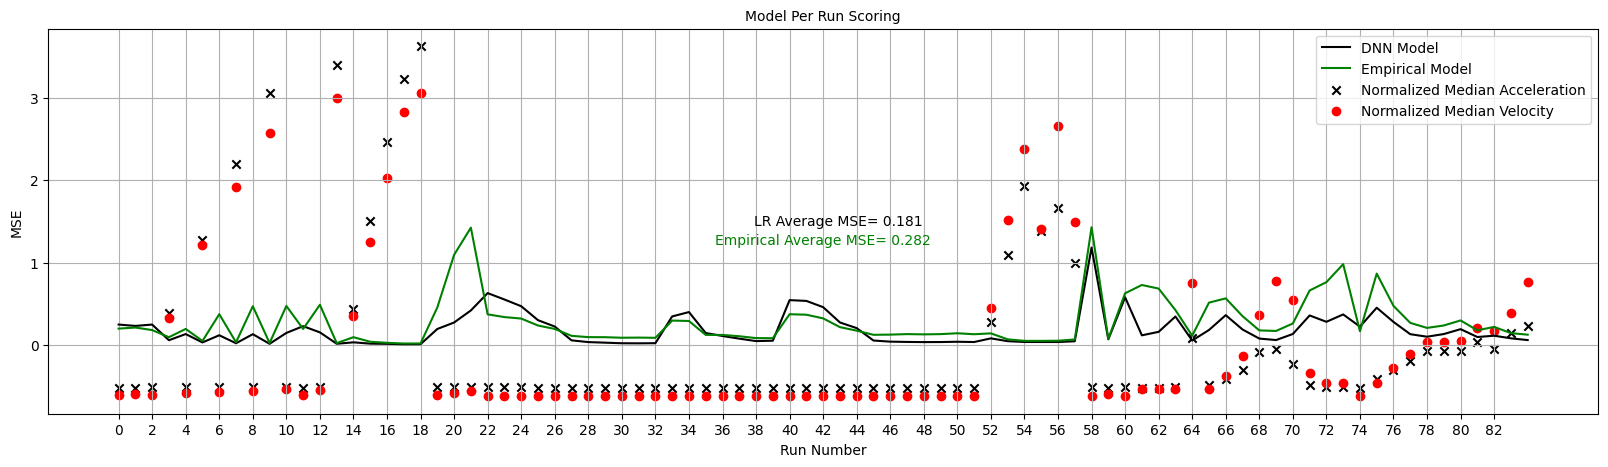

In [ ]:
importlib.reload(post_process)
importlib.reload(preprocess_data)
importlib.reload(DNN_functions)
MSE, MAE, MSE_empirical, MAE_empirical, data, Ax_Median, Vx_Median = post_process.test_scores(
    model      = model.cpu(),
    model_type = model_type, 
    norm_params  = norm_params)

post_process.model_per_run_scoring(MSE, Vx_Median, Ax_Median, MSE_empirical, model_name = model_type + " Model")

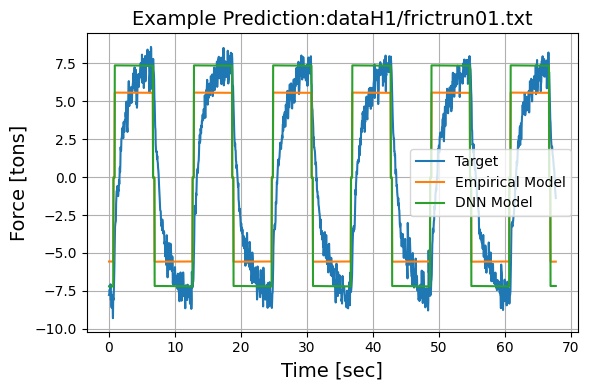

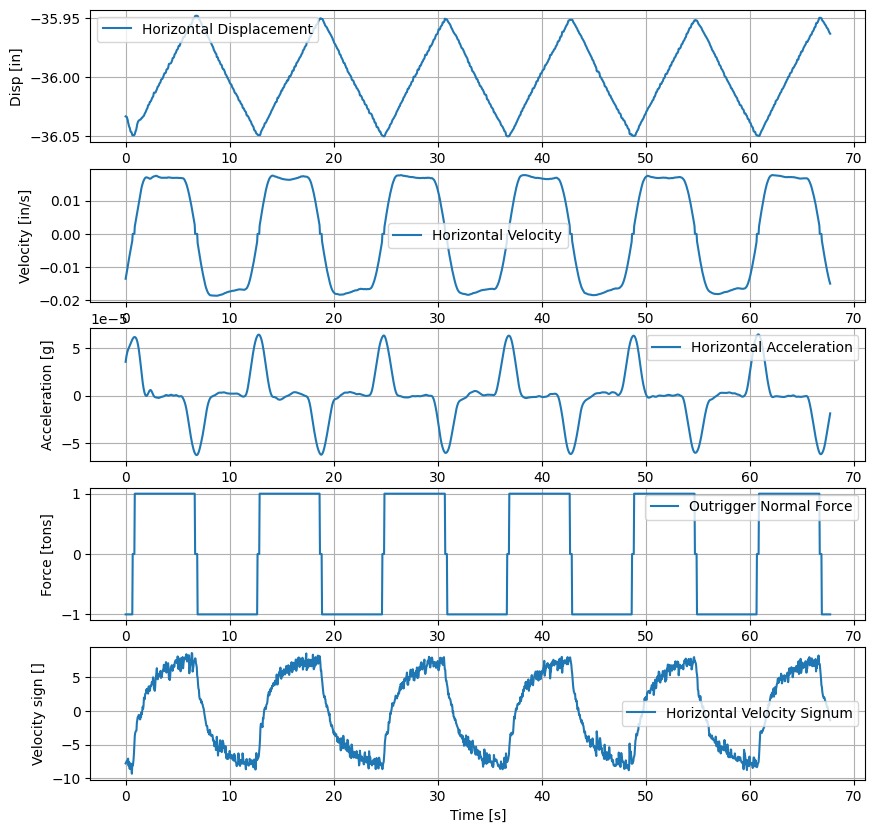

In [ ]:
prediction, empirical_prediction, signals, time, run_name = data[40]

# target and prediction plot
post_process.plot_prediction(time, signals, empirical_prediction, prediction, run_name, model_name = model_type + " Model")
post_process.plot_signals(signals, time)

## 6. Conclusions <a class="anchor" id="sixth-bullet">
Description...